***USED FOR ANALYSIS OF TRANSCRIPTION***

**TO DO** 

- Remove filler words and do csv analysis.
- Find which words come in as replacement and make graphs
- What to do with gaap and EBITDA

In [42]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re
import pandas as pd
from rapidfuzz import fuzz, process
import random
import warnings
from pathlib import Path
from matplotlib.patches import Patch



In [43]:

def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_variants(root_folder, suffixes):
    all_pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            gt_file = [f for f in files if f.endswith('.txt') and not any(f.endswith(suffix) for suffix in suffixes) and not f.endswith('_timing.txt')]
            if not gt_file:
                continue
            gt_path = os.path.join(full_path, gt_file[0])
            for suffix in suffixes:
                hyp_file = [f for f in files if f == f"{subdir}{suffix}"]
                if hyp_file:
                    hyp_path = os.path.join(full_path, hyp_file[0])
                    all_pairs.append((subdir, suffix, gt_path, hyp_path))
    return all_pairs

def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        gt_tokens = clean_and_tokenize(gt)
        hyp_tokens = clean_and_tokenize(hyp)
        gt_clean = ' '.join(gt_tokens)
        hyp_clean = ' '.join(hyp_tokens)
        metrics = compute_metrics(gt_clean, hyp_clean)

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_text": gt_clean,
            "hyp_text": hyp_clean,
            "gt_word_count": len(gt_tokens),
            "hyp_word_count": len(hyp_tokens)
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    # Total word count printout
    summary = df_paths.groupby("variant")[["gt_word_count", "hyp_word_count"]].sum()
    print(f"\n{base_folder} — Total word counts:")
    print(summary)

    return df_metrics, df_paths


variant_name_map = {
    '_Whisper.txt': 'whisper-small',
    '_Turbo_Whisper.txt': 'whisper-large-v3-turbo',
    '_openai_transcript.txt': 'GPT-4o mini Transcribe'
}

suffixes = ['_Whisper.txt', '_openai_transcript.txt', '_Turbo_Whisper.txt']
df_21, df_paths_21 = evaluate_folder_variants('Data/combined_21', suffixes)
print("Combined 21 summary:")
print(df_21.groupby("variant").describe())

df_22, df_paths_22 = evaluate_folder_variants('Data/combined_22', suffixes)
print("\nCombined 22 summary:")
print(df_22.groupby("variant").describe())


Data/combined_21 — Total word counts:
                        gt_word_count  hyp_word_count
variant                                              
GPT-4o mini Transcribe         362220          334842
whisper-large-v3-turbo         362220          341789
whisper-small                  362220          342800
Combined 21 summary:
                         wer                                          \
                       count      mean       std       min       25%   
variant                                                                
GPT-4o mini Transcribe  44.0  0.138832  0.039241  0.076688  0.112188   
whisper-large-v3-turbo  44.0  0.139673  0.039771  0.074037  0.115989   
whisper-small           44.0  0.165045  0.044106  0.108366  0.135530   

                                                       mer            ...  \
                             50%       75%       max count      mean  ...   
variant                                                               ...   
GPT-4o

In [19]:
# Path to the folder with the 3 txt files
folder = Path("Data/combined_21/4366522")

# Load files
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return ' '.join(text.split())        # normalize whitespace
ground_truth = clean_and_tokenize((folder / "4366522.txt").read_text(encoding="utf-8"))
hypothesis1 = clean_and_tokenize((folder / "4366522_Turbo_Whisper.txt").read_text(encoding="utf-8"))
hypothesis2 = clean_and_tokenize((folder / "4366522simple.txt").read_text(encoding="utf-8"))
# Compute WER
wer1 = wer(ground_truth, hypothesis1)
wer2 = wer(ground_truth, hypothesis2)

# Print results
print(f"WER for transcription1.txt: {wer1}")
print(f"WER for transcription2.txt: {wer2}")


WER for transcription1.txt: 0.11495911495911496
WER for transcription2.txt: 0.0998075998075998


In [20]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.5)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 50%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 50%:
variant
GPT-4o mini Transcribe    4.0
whisper-large-v3-turbo    1.6
whisper-small             3.2
Name: over_50, dtype: float64



=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.139
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.196
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.140
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.194
whisper-small                  | Earnings21   → Mean WER: 0.165
whisper-small                  | Earnings22   → Mean WER: 0.227

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.137
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.189
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.137
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.186
whisper-small                  | Earnings21   → Mean MER: 0.161
whisper-small                  | Earnings22   → Mean MER: 0.215

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.178
GPT-4o mini Transcribe         | Earnings22  

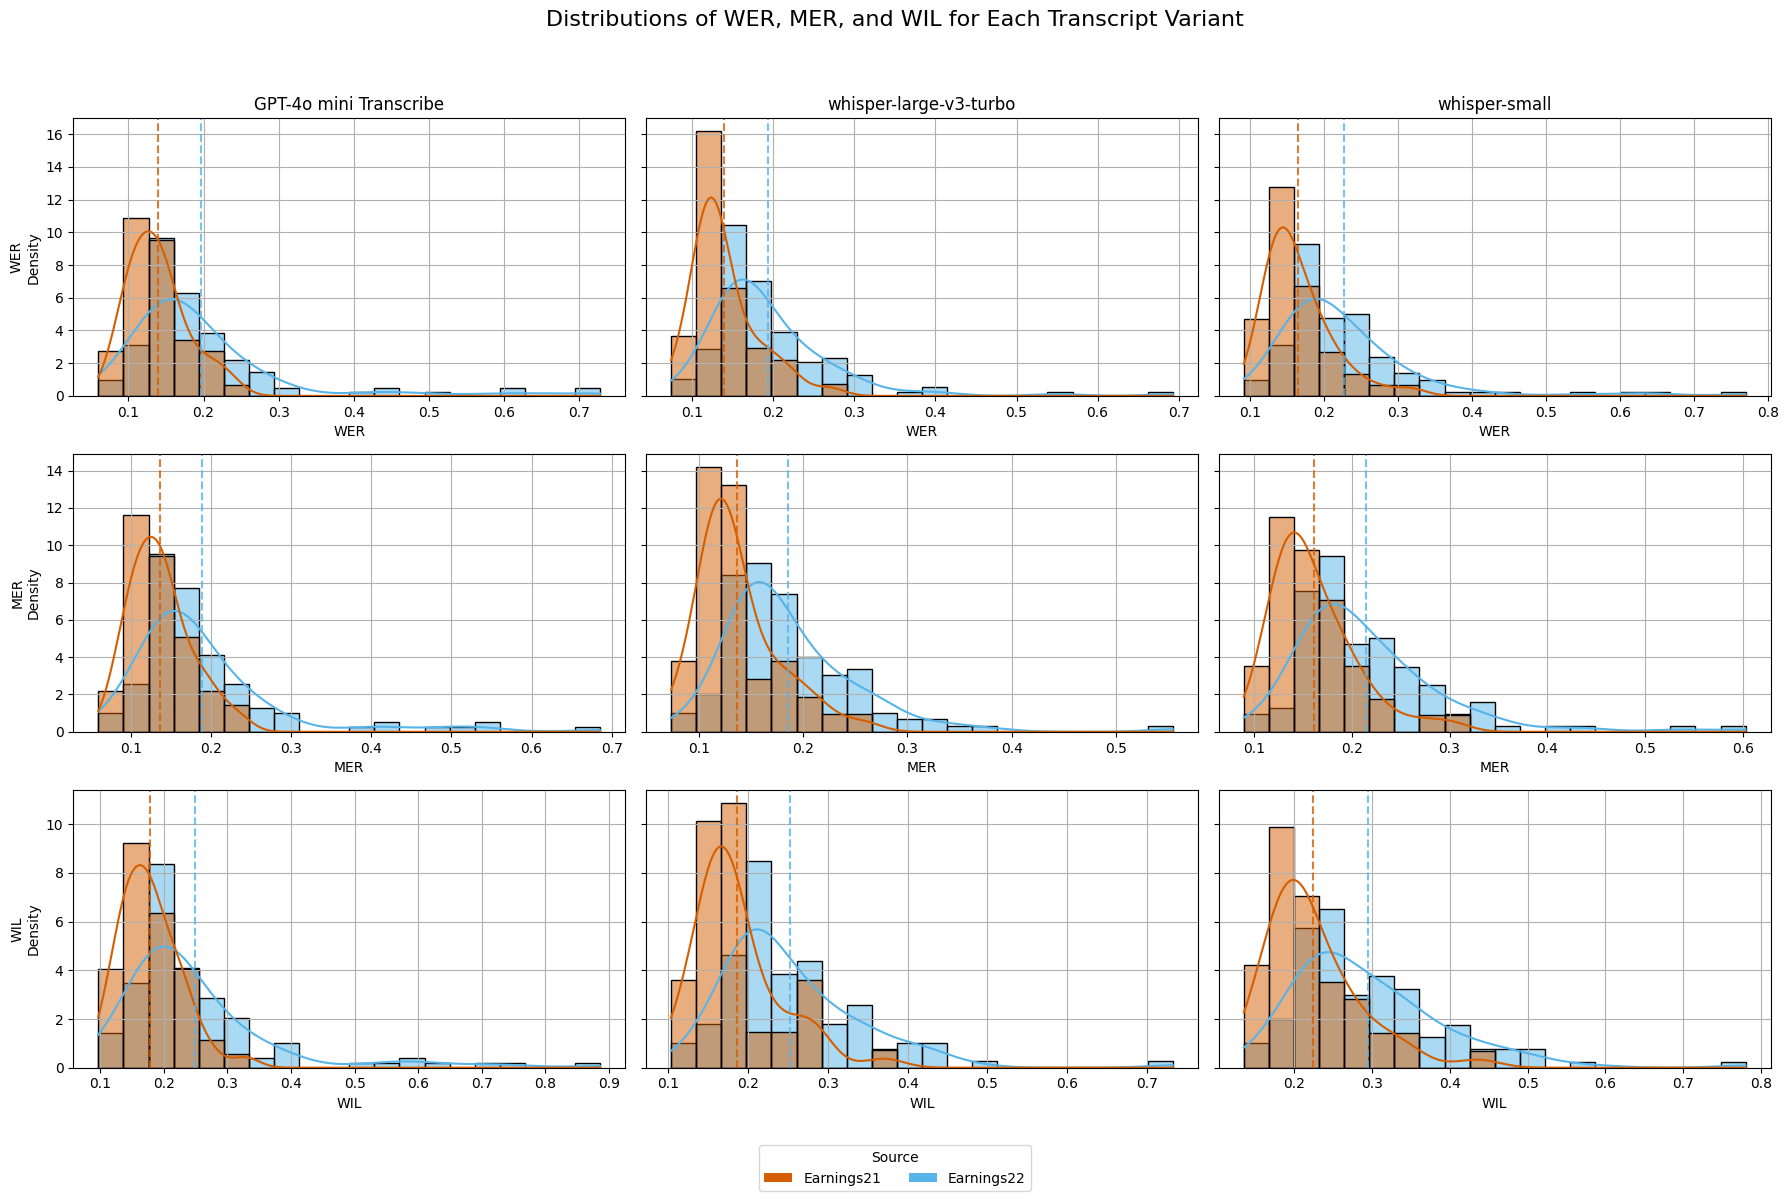

In [ ]:

# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


I want to find filler words that are only in the ground truth but not the transcripts


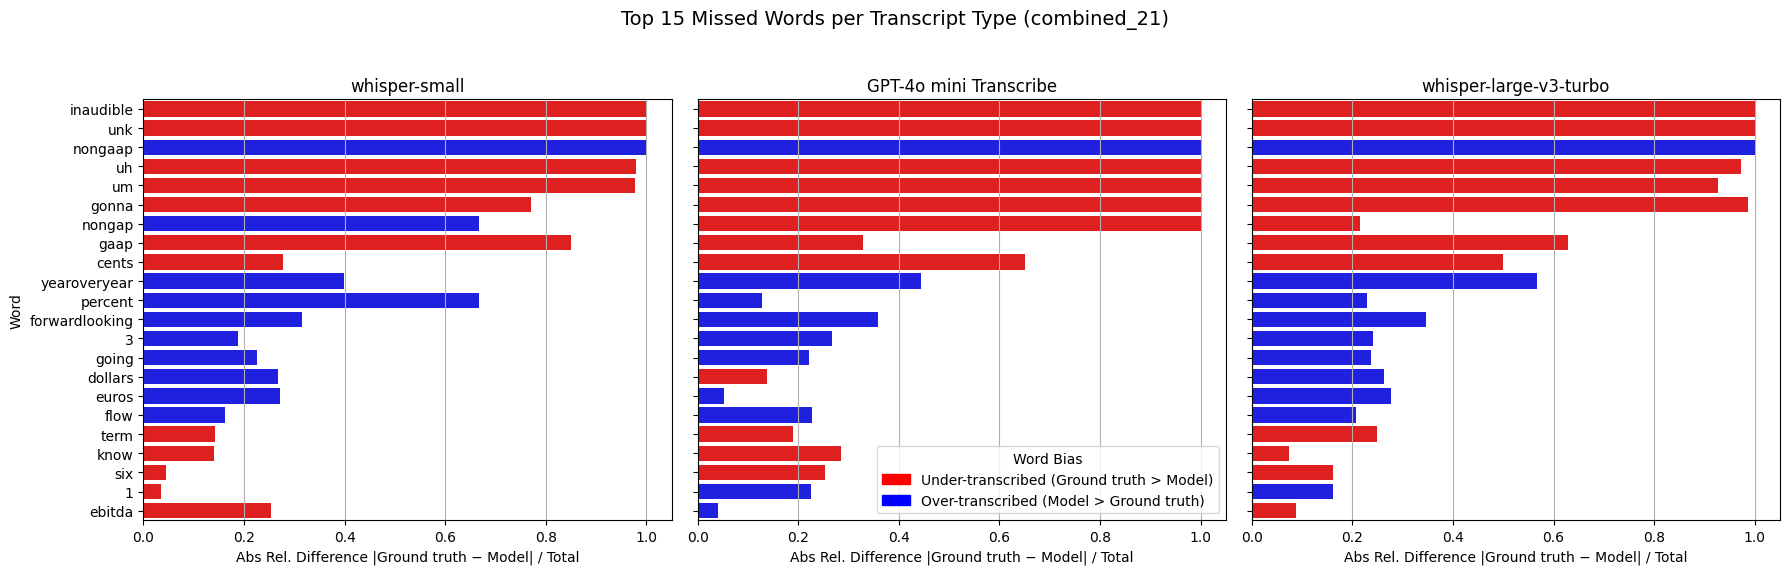

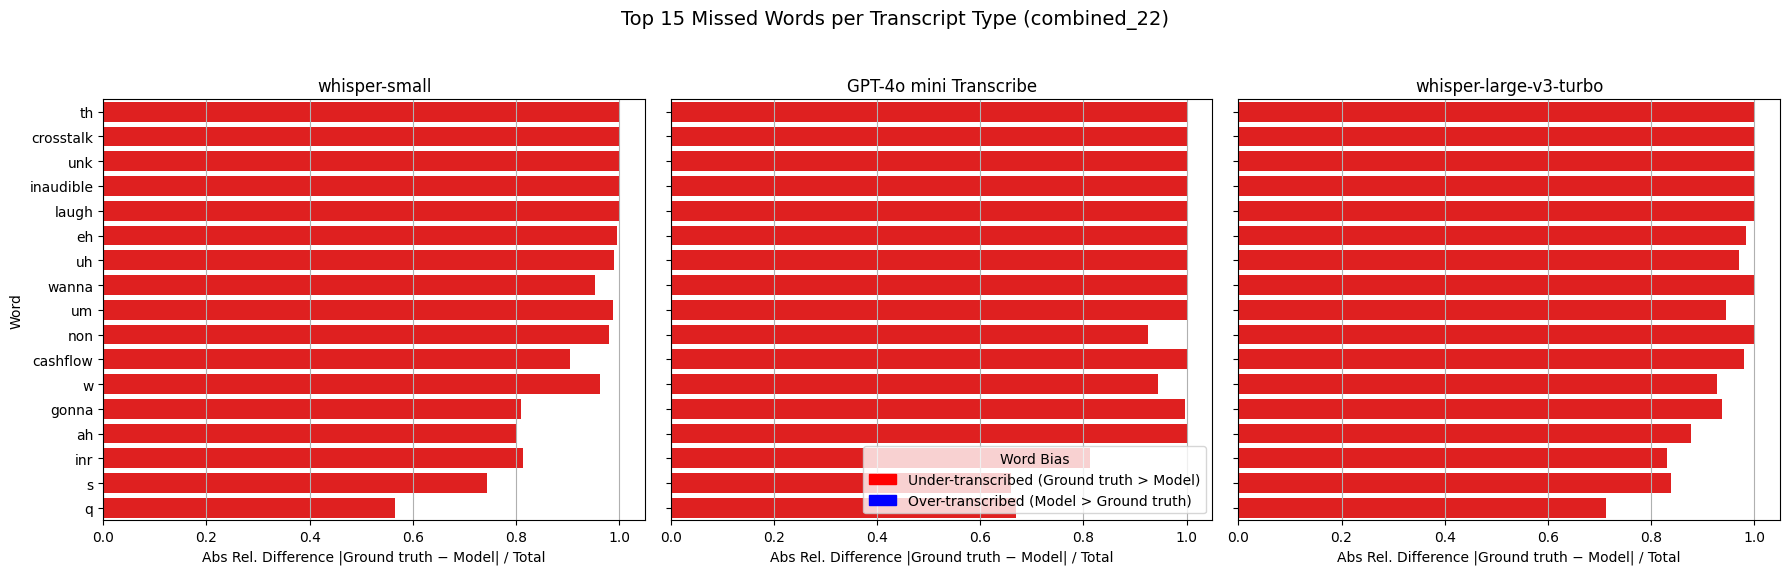

In [22]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", "th", "mmhmm", "hmm", "ah", "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

-  Altering: Cashflow to Cash flow, Gonna to Going to, Wanna to Want to, Health care to healthcare



In [48]:
# Define substitutions and fillers
SUBSTITUTIONS = {
    "gonna": ["going", "to"],
    "wanna": ["want", "to"],
    "gotta": ["got", "to"],
    "qoq:": ["q", "o", "q"],
    "kinda": ["kind", "of"],
    "cashflow": ["cash", "flow"],
    "yearoveryear": ["year", "over", "year"],
    "yearonyear": ["year", "on", "year"],
    "s": ["is"],
    "forwardlooking": ["forward", "looking"],
    "one": ["1"],
    "two": ["2"],
    "three": ["3"],
    "four": ["4"],
    "five": ["5"],
    "six": ["6"],
    "seven": ["7"],
    "eight": ["8"],
    "nine": ["9"],
    "hundred": ["100"],
    "thousand": ["1000"],
    "followup": ["follow", "up"],
    "longterm": ["long", "term"],
    "shortterm": ["short", "term"],
    "healthcare": ["health", "care"],
    "singledigit": ["single", "digit"],
    "doubledigit": ["double", "digit"],
    "midsingledigit": ["mid", "single", "digit"],
    "midsingle" : ["mid", "single"],
    "oneoff": ["one", "off"]

}
FILLERS = {"eh", "uh", "um", "w", "th", "mmhmm", "hmm", "em", "ah", "e", "y", "inaudible", "unk", "crosstalk", "laugh", "oh", "affirmative", "q", "gaap", "gap", "percent"}

PREFIX_SPLITS = {"non", "pre"}



def apply_substitutions(tokens):
    output = []

    for token in tokens:
        # Check for prefix-based splits
        matched = False
        for prefix in PREFIX_SPLITS:
            if token.startswith(prefix) and len(token) > len(prefix):
                output.extend([prefix, token[len(prefix):]])
                matched = True
                break  # only split once, at first matched prefix

        if matched:
            continue
        output.extend(SUBSTITUTIONS.get(token, [token]))

    return output

def evaluate_cleaned_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)

        gt_words = apply_substitutions(clean_and_tokenize(gt))
        hyp_words = apply_substitutions(clean_and_tokenize(hyp))

        gt_filler_count = sum(word in FILLERS for word in gt_words)
        hyp_filler_count = sum(word in FILLERS for word in hyp_words)

        gt_cleaned = [w for w in gt_words if w not in FILLERS]
        hyp_cleaned = [w for w in hyp_words if w not in FILLERS]

        metrics = compute_metrics(' '.join(gt_cleaned), ' '.join(hyp_cleaned))
        variant = suffix.replace('.txt', '').replace('_', '')

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_word_count": len(gt_words),
            "gt_filler_count": gt_filler_count,
            "gt_word_count_clean": len(gt_cleaned),
            "hyp_word_count": len(hyp_words),
            "hyp_filler_count": hyp_filler_count,
            "hyp_word_count_clean": len(hyp_cleaned),
            "gt_text": ' '.join(gt_cleaned),        
            "hyp_text": ' '.join(hyp_cleaned)   
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    print(f"\n{base_folder} —")
    print(df_paths.groupby("variant")[["gt_word_count", "gt_filler_count", "hyp_word_count", "hyp_filler_count"]].sum())
    return df_metrics, df_paths

# Run on all variants
suffixes = ['_Whisper.txt', '_Turbo_Whisper.txt', '_openai_transcript.txt']
df_21, df_paths_21 = evaluate_cleaned_variants("Data/combined_21", suffixes)
df_22, df_paths_22 = evaluate_cleaned_variants("Data/combined_22", suffixes)


Data/combined_21 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe         364486            11828          337022   
whisper-large-v3-turbo         364486            11828          344066   
whisper-small                  364486            11828          344982   

                        hyp_filler_count  
variant                                   
GPT-4o mini Transcribe               284  
whisper-large-v3-turbo               520  
whisper-small                        602  

Data/combined_22 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe        1008593            49711          924965   
whisper-large-v3-turbo        1008593            49711          948775   
whisper-small                 1008593            49711          954923   

   


=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.108
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.159
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.110
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.159
whisper-small                  | Earnings21   → Mean WER: 0.137
whisper-small                  | Earnings22   → Mean WER: 0.194

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.106
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.151
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.108
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.149
whisper-small                  | Earnings21   → Mean MER: 0.133
whisper-small                  | Earnings22   → Mean MER: 0.179

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.142
GPT-4o mini Transcribe         | Earnings22  

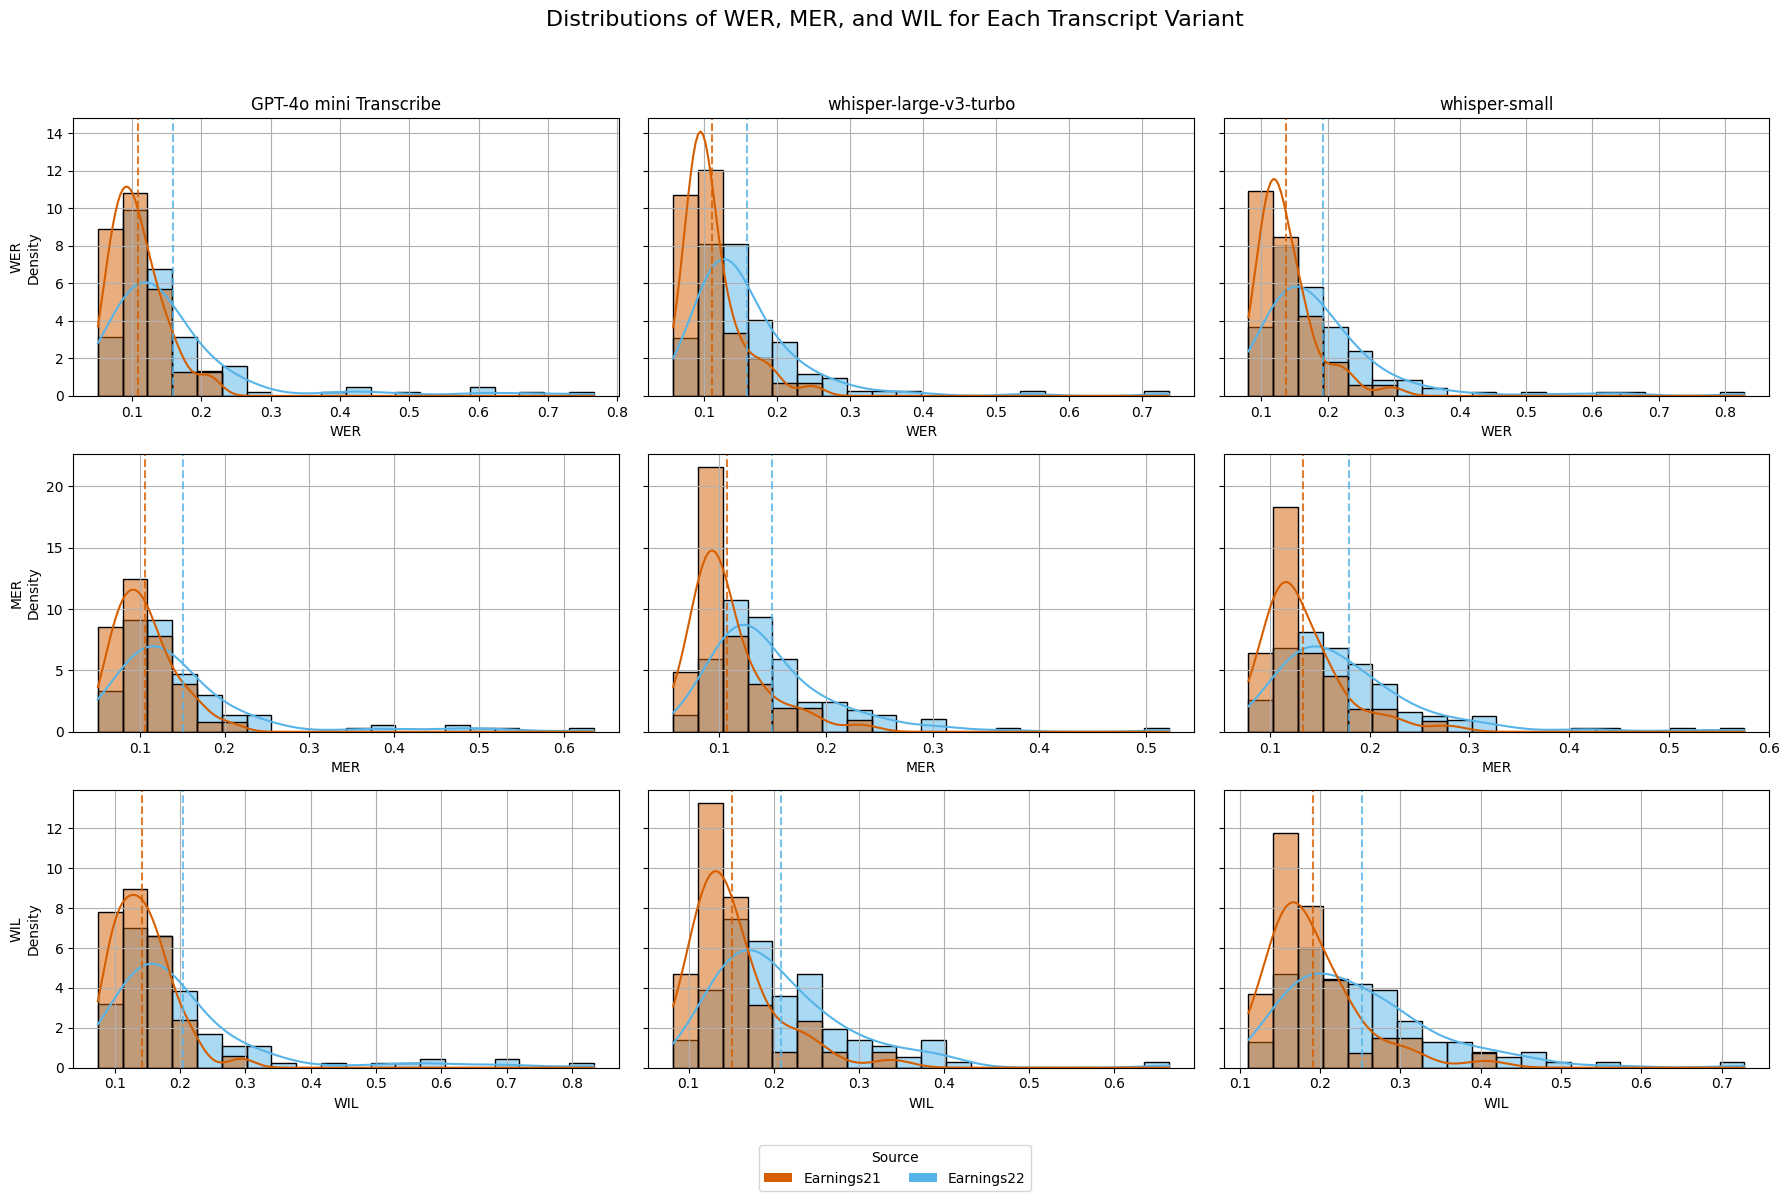

In [49]:
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


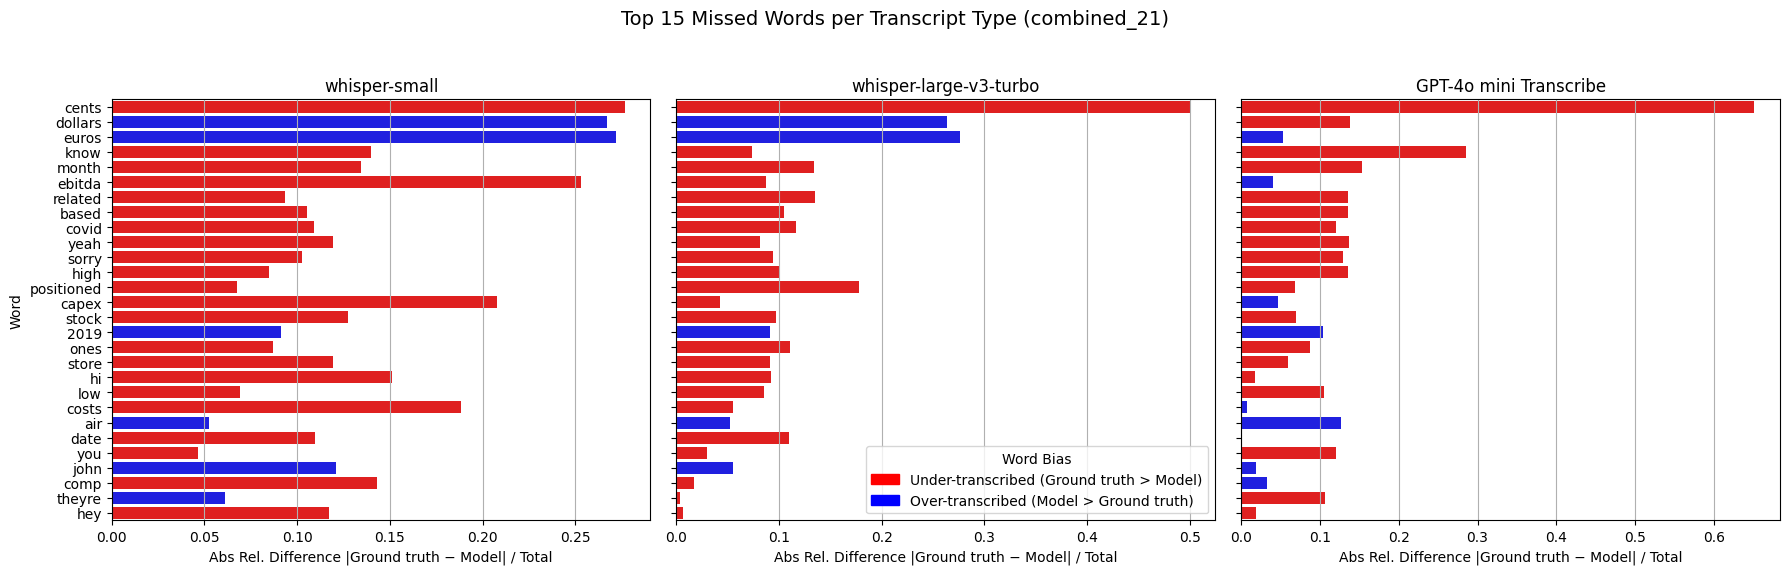

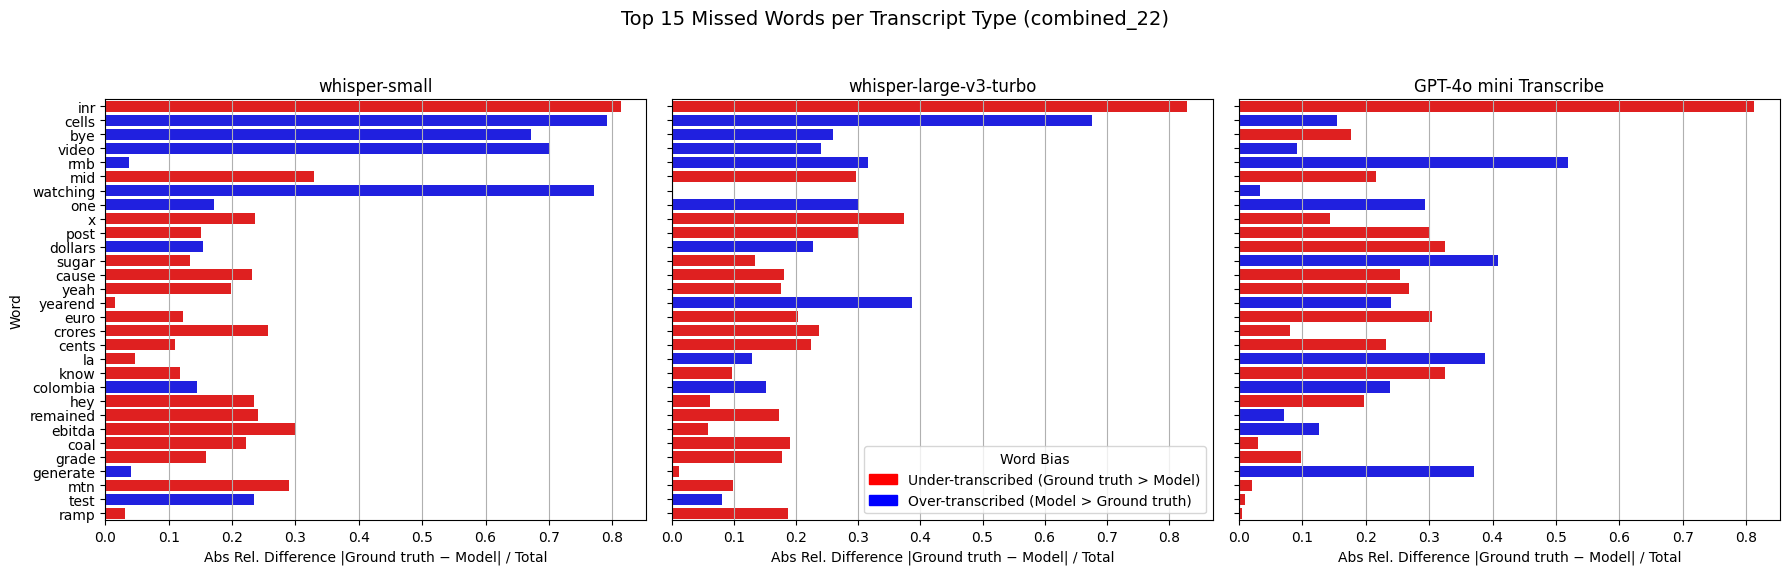

In [31]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


In [ ]:
from collections import Counter
import re
import pandas as pd
from difflib import SequenceMatcher

def extract_numbers(text):
    return re.findall(r'\d+(?:\.\d+)?', text)

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

def evaluate_number_accuracy(df_paths):
    results = []
    variants = df_paths['variant'].unique()

    for variant in variants:
        df_var = df_paths[df_paths['variant'] == variant]

        gt_total = 0
        pred_total = 0
        correct_total = 0

        for _, row in df_var.iterrows():
            gt_numbers = extract_numbers(row['gt_text'])
            hyp_numbers = extract_numbers(row['hyp_text'])

            gt_total += len(gt_numbers)
            pred_total += len(hyp_numbers)
            correct_total += count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct_total / pred_total if pred_total else 0
        recall = correct_total / gt_total if gt_total else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        results.append({
            'variant': variant,
            'gt_total': gt_total,
            'pred_total': pred_total,
            'correct': correct_total,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    # Compute overall totals
    totals = pd.DataFrame(results).sum(numeric_only=True)
    total_correct = totals['correct']
    total_pred = totals['pred_total']
    total_gt = totals['gt_total']
    total_precision = total_correct / total_pred if total_pred else 0
    total_recall = total_correct / total_gt if total_gt else 0
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) else 0

    results.append({
        'variant': 'TOTAL',
        'gt_total': total_gt,
        'pred_total': total_pred,
        'correct': total_correct,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1
    })

    df_result = pd.DataFrame(results)
    print(df_result.to_string(index=False, float_format='%.3f'))
    return df_result

print("Number accuracy for combined_21:")
evaluate_number_accuracy(df_paths_21)
print("\nNumber accuracy for combined_22:")
evaluate_number_accuracy(df_paths_22)


Number accuracy for combined_21:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  8489.000    8413.000  7080.000      0.842   0.834 0.838
whisper-large-v3-turbo  8489.000    8370.000  7135.000      0.852   0.840 0.846
GPT-4o mini Transcribe  8489.000    8256.000  7251.000      0.878   0.854 0.866
                 TOTAL 25467.000   25039.000 21466.000      0.857   0.843 0.850

Number accuracy for combined_22:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small 27988.000   27533.000 22138.000      0.804   0.791 0.797
whisper-large-v3-turbo 27988.000   27318.000 23047.000      0.844   0.823 0.833
GPT-4o mini Transcribe 27988.000   27183.000 23619.000      0.869   0.844 0.856
                 TOTAL 83964.000   82034.000 68804.000      0.839   0.819 0.829


,variant,gt_total,pred_total,correct,precision,recall,f1
0,whisper-small,27988.0,27533.0,22138.0,0.804053,0.790982,0.797464
1,whisper-large-v3-turbo,27988.0,27318.0,23047.0,0.843656,0.823460,0.833436
2,GPT-4o mini Transcribe,27988.0,27183.0,23619.0,0.868889,0.843897,0.856211
3,TOTAL,83964.0,82034.0,68804.0,0.838725,0.819446,0.828974


**LONG RUNNING TIME BLOCKS**

Making lists of examples:

In [ ]:
import pandas as pd
import random
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

# Seed for reproducibility
random.seed(42)

# Combine top word lists
top_words = list(set(ordered_words_21 + ordered_words_22))

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30

# Store results
context_examples = {word: [] for word in top_words}

datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text'].lower()
        whisper_text = row['hyp_text'].lower()  # Assuming this column is the model output

        gt_words = re.findall(r'\b\w+\b', gt_text)
        whisper_words = re.findall(r'\b\w+\b', whisper_text)

        whisper_snippets = [
            ' '.join(whisper_words[i:i + chunk_size])
            for i in range(len(whisper_words) - chunk_size + 1)
        ]

        # Index locations of top words in GT
        word_indices = defaultdict(list)
        for i, token in enumerate(gt_words):
            if token in top_words:
                word_indices[token].append(i)

        for token, indices in word_indices.items():
            sampled_indices = random.sample(indices, min(sample_limit, len(indices)))
            for i in sampled_indices:
                start = max(i - 10, 0)
                end = min(i + 11, len(gt_words))
                gt_snippet = ' '.join(gt_words[start:end])

                # Estimate where to look in hypothesis
                approx_chunk = int(i * len(whisper_snippets) / len(gt_words))
                chunk_start = max(approx_chunk - window_range, 0)
                chunk_end = min(approx_chunk + window_range + 1, len(whisper_snippets))
                local_snippets = whisper_snippets[chunk_start:chunk_end]

                best_match, score, _ = process.extractOne(
                    gt_snippet, local_snippets, scorer=fuzz.partial_ratio
                )

                whisper_match = best_match if best_match else '[No match found]'
                whisper_start_index = (
                    chunk_start + local_snippets.index(best_match)
                    if best_match in local_snippets else -1
                )

                context_examples[token].append({
                    'word': token,
                    'gt_snippet': gt_snippet,
                    'gt_index': i,
                    'whisper_snippet': whisper_match,
                    'whisper_index': whisper_start_index,
                    'score': score,
                    'dataset': label,
                    'folder': row['folder']
                })

# Flatten and save as CSV
rows = [example for word_examples in context_examples.values() for example in word_examples]
df_context = pd.DataFrame(rows)
df_context.to_csv('top_word_context_examples.csv', index=False)
print(f"Saved {len(df_context)} examples to 'top_word_context_examples.csv'")


Saved 42960 examples to 'top_word_context_examples.csv'


In [ ]:
rows = []

for word, examples in context_examples.items():
    for ex in examples:
        rows.append({
            "word": word,
            "gt_snippet": ex['gt_snippet'],
            "whisper_snippet": ex['whisper_snippet'],
            "gt_index": ex['gt_index'],
            "whisper_index": ex['whisper_index'],
            "score": ex['score'],
            "folder": ex['folder'],
            "dataset": ex['dataset']
        })

df_matches = pd.DataFrame(rows)
df_matches.to_csv("gt_whisper_matches.csv", index=False)
